In [1]:
from result_records import DataFrameLoader

DENSE_SMALL = '/mnt/ssd-1/transformer-memorization/memorization_results_dense_small.csv'
DENSE_MEDIUM = '/mnt/ssd-1/transformer-memorization/memorization_results_dense_medium.csv'
DENSE_LARGE = '/mnt/ssd-1/transformer-memorization/memorization_results_dense_large.csv'

data_labels = [
    'dense_small (150M)',
    'dense_medium (350M)',
    'dense_large (750M)'
]

In [2]:
datasets = [DataFrameLoader(i) for i in [DENSE_SMALL,DENSE_MEDIUM,DENSE_LARGE]]

# Loading Data 

In [3]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm

data = {}
for i,(ds,label) in enumerate(zip(datasets,data_labels)):
    
    loss = []
    indicies = []
    for i,(idx,res) in tqdm(enumerate(ds)):
        if(not (np.isnan(res) or np.isinf(res))):
            loss.append(res)
            indicies.append(idx*2048) #token indicies
    data[label] = [np.array(indicies),np.array(loss)]
    
        


2460176it [00:12, 203587.21it/s]
2585494it [00:12, 203711.86it/s]
2585497it [00:12, 202769.37it/s]


# Memorization Metric plots
> Plotting average values of memorization metric over a bucketed range of values

In [4]:
# Run these if you don't see UI for the plots and refresh the page
#!pip install --upgrade jupyter_core jupyter_client
#!jupyter nbextension enable --py widgetsnbextension

In [6]:
from IPython.display import display
import matplotlib.pyplot as plt
import ipywidgets as widgets


import numpy as np

class Plotter:
    size = 25
    params = {'legend.fontsize': 'large',
          'figure.figsize': (15,5),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25,
          'font.family':'sans-serif',
          'font.weight':'bold',
         }
    
    def __init__(self,title,data,size=25,xlabel=None,ylabel=None,
                 default_slider_value=None,plot_group=False,
                 plot_type="error_bars",colors=None):
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.default_slider_value = default_slider_value
        self.data = data
        self.plot_group = plot_group
        self.colors = colors
        if(not self.colors):
            self.colors = [None for i in range(len(data.keys()))]
        
    
    def plot_data(self,data,num_buckets,label,c_idx):
        if(len(data) == 2):
            x,y = data
        elif(len(data) == 1):
            y, = data
            x = [i for i in range(len(y))]
        else:
            raise ValueError(f'Only two axis are supported, not {len(data)} axes') 
            
        assert len(x) == len(y)
        
            
        bucket_size = len(x)//num_buckets

        buckets = []
        index = []
        err = []
        for i in range(0,len(x),bucket_size):
            buckets.append(y[i:i+bucket_size].mean())
            index.append(x[min(i+bucket_size-1,len(x)-1)])
            err.append(y[i:i+bucket_size].std()/np.sqrt(bucket_size))

        buckets = buckets[:num_buckets]
        index = index[:num_buckets]
        err = err[:num_buckets]
        plt.errorbar(index,buckets,yerr = err,label=label,capsize=5,color=self.colors[c_idx])
    
    def plot(self,num_buckets):
        plt.rcParams.update(self.params)
        for idx,(key,value) in enumerate(self.data.items()):
            self.plot_data(value,num_buckets,key,idx)
            
            if(not self.plot_group):
                
                plt.title(self.title)
                plt.xlabel(self.xlabel)
                plt.ylabel(self.ylabel)
                plt.legend()
                plt.show()
        
        if(self.plot_group):
            plt.title(self.title)
            plt.xlabel(self.xlabel)
            plt.ylabel(self.ylabel)
            plt.legend()
            plt.show()
    
    def clicked(self,b):
        self.out.clear_output()
        scale = self.slider.value
        with self.out:
            self.plot(scale)
    def run(self):
        self.out = widgets.Output()
        button = widgets.Button(description="Plot Value")
        slider_max = 50
        
        if(self.default_slider_value is not None):
            default_slider_value = self.default_slider_value
        else:
            default_slider_value = np.random.choice([i for i in range(1,slider_max)])
        self.slider = widgets.IntSlider(min=1, max=slider_max, 
                                   value=default_slider_value,
                                   description="Bins",
                                   layout=widgets.Layout(width='50%'))

        box_layout = widgets.Layout(
            display='flex',
            flex_flow='column',
            align_items='center',
            width='80%'
        )

        box = widgets.VBox(
            [
                self.out,
                self.slider,
                button
            ],
            layout=box_layout
        )

        

        with self.out:    
            self.plot(default_slider_value)
        button.on_click(self.clicked)
        display(box)
    
plotter = Plotter(title="Memorization Metric",
                  xlabel='Token index',ylabel='NLL Loss',
                  data=data,plot_group=False,colors = ['blue','green','red'])
plotter.run() #Refresh if you donot see UI

# Scatter plot

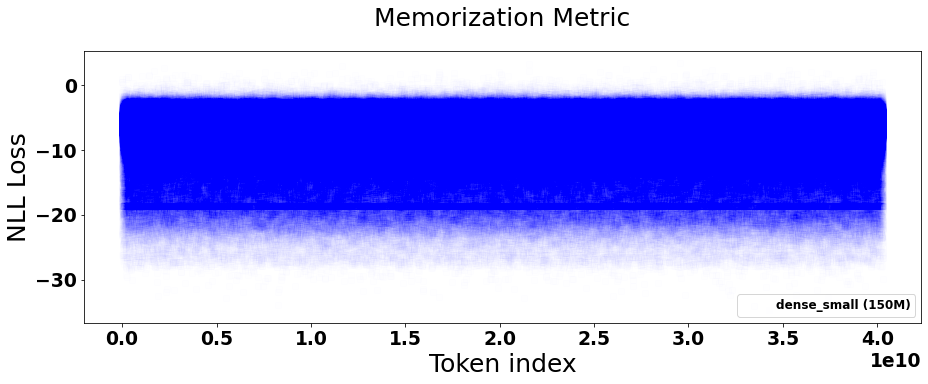

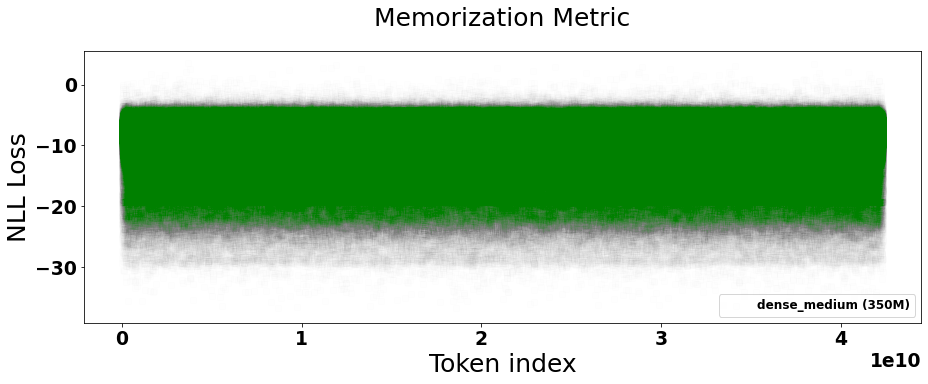

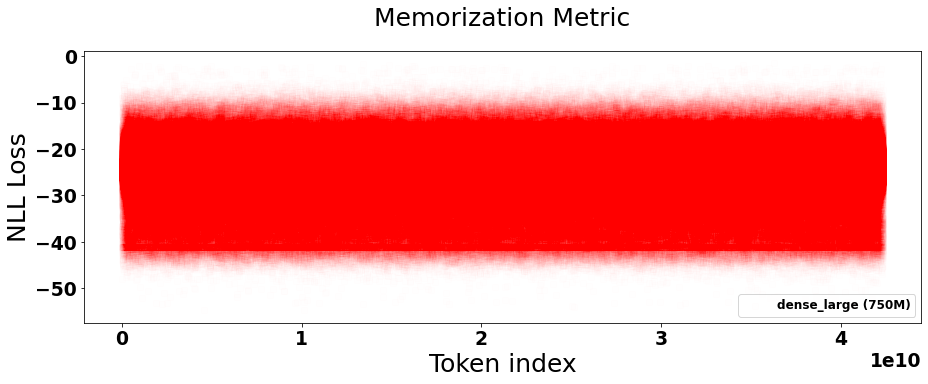

In [7]:
plt.rcParams.update(Plotter.params)
colors = ['blue','green','red']
for label,color in zip(data_labels,colors):
    plt.scatter(data[label][0],data[label][1],label=label,marker=',',alpha=0.002,color=color)

    plt.title("Memorization Metric")
    plt.xlabel('Token index')
    plt.ylabel('NLL Loss')
    plt.legend(loc='lower right')
    plt.show()

# Correlation

[63183546.10454956 63157170.04414661 63147018.49606542 ...
 63170236.67467693 63147018.49606539 63157170.04414665]


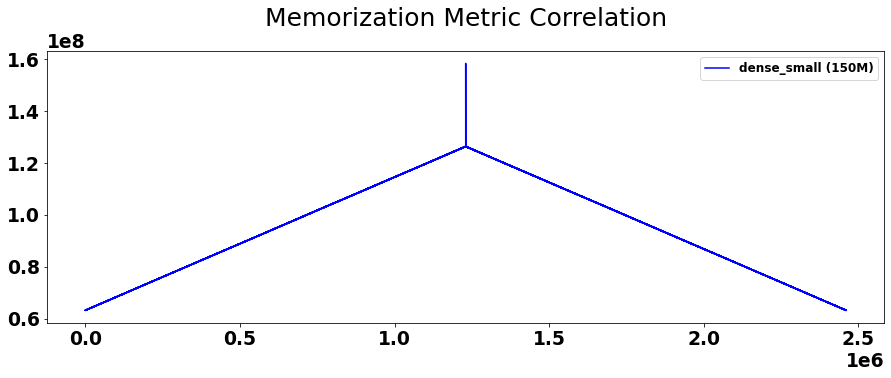

[1.05086905e+08 1.05086175e+08 1.05075312e+08 ... 1.05078639e+08
 1.05075312e+08 1.05086175e+08]


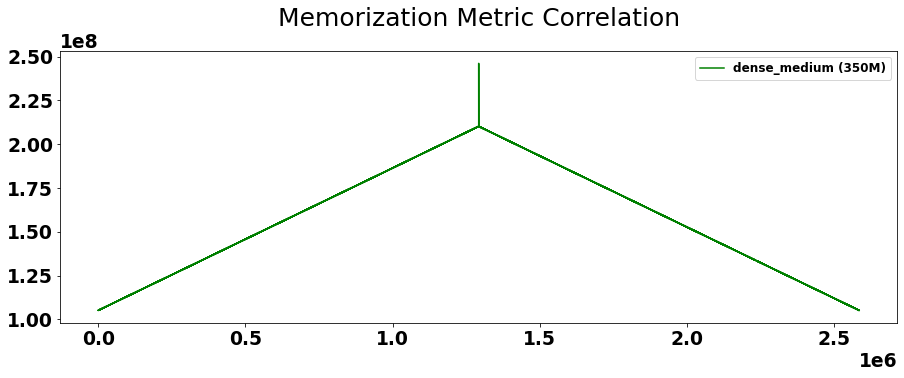

[7.69736533e+08 7.69720291e+08 7.69800399e+08 ... 7.69753172e+08
 7.69800399e+08 7.69720291e+08]


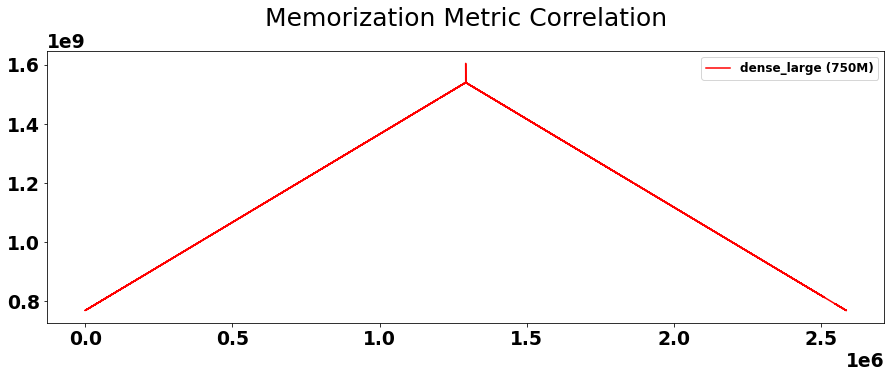

In [16]:
from scipy import signal
for label,color in zip(data_labels,colors):
    correlation = signal.correlate(data[label][1],data[label][1],mode='same')
    print(correlation)
    plt.plot(correlation,label=label,color=color)

    plt.title("Memorization Metric Correlation")
    plt.legend(loc='upper right')
    plt.show()
    

# Linear regression of Memorization metric

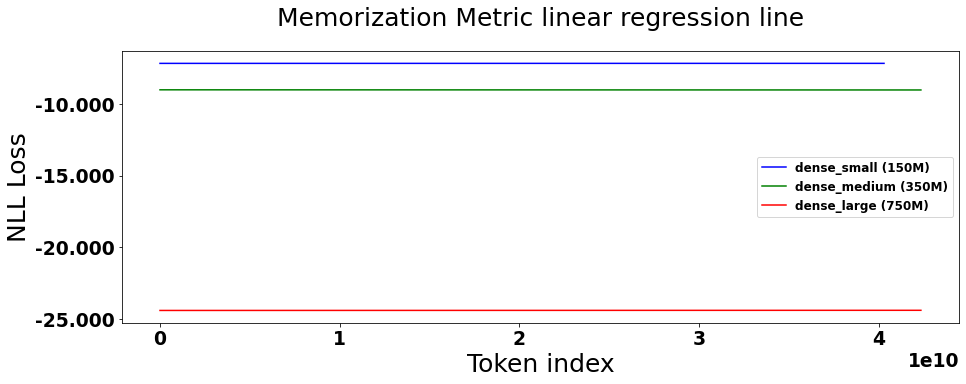

In [12]:
from matplotlib import ticker
plt.rcParams.update(Plotter.params)
colors = ['blue','green','red']
fig,ax = plt.subplots()
for label,color in zip(data_labels,colors):
    x = np.array(data[label][0])
    m, b = np.polyfit(data[label][0],data[label][1],1)
    ax.plot(x,m*x +b,label=label,color=color)

ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
plt.title("Memorization Metric linear regression line")
plt.xlabel('Token index')
plt.ylabel('NLL Loss')
    
plt.legend()
plt.show()

# Statistics

In [10]:
import matplotlib.pyplot as plt

SAMPLE_VALUE = len(data)*25//100
from sklearn.metrics import r2_score
r2 = r2_score(indicies,data)
print(f"R2 Score between indicies and data: {r2:.5f}")
avg_start = data[:SAMPLE_VALUE].mean()
avg_end = data[SAMPLE_VALUE:].mean()

var_start = data[:SAMPLE_VALUE].var()
var_end = data[SAMPLE_VALUE:].var()
print(f"Average NLL Loss changed from {avg_start:.5f} to {avg_end:.5f}")
print(f"Varience of  NLL Loss changed from {var_start:.5f} to {var_end:.5f}")
print("Trend of very slight improvement continues")

R2 Score between indicies and data: -3.00108
Average NLL Loss changed from -8.98532 to -8.95018
Varience of  NLL Loss changed from 14.02080 to 13.66236
Trend of very slight improvement continues
